In [1]:
import sys

sys.path.append("/home/jerryjin/moth-meg-dataset/")  # change to your own path

import os, glob
import mne
import numpy as np
import pickle
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
from src.correct_delay_funcs import *

### Set Parameters

First, we specify which session and subject we will be considering for analysis.

In [2]:
SUBJECT = "D"
SESSION = "Moth1"
BLOCKS = ["01", "02", "03", "04", "05", "06", "07", "08"]
LOC_AUDIO = "/project_data/volume0/lwehbe/ds003020/stimuli/"
LOC_RAW = f"/project_data/volume0/jerryjin/moth_meg/{SESSION}/mysss_myafter/{SUBJECT}/"
LOC_SAVE = f"/project_data/volume0/jerryjin/moth_meg/{SESSION}/delay_correction/"
SAVE_ACOUSTIC = True

Next, we will define some general objects. The story order is specified during the experimental setup. It is important to keep a log file for every single session (time where a subject goes to the scanner) that indicates exactly which stories were played. Note that for Moth1, block 1 is the audio localizer. We might not want to include that in other formal analysis.

In [3]:
# stories in each session, in order
session_stories_dict = dict(
    Moth1=["stimuli_auditory_localizer", "alternateithicatom1", "souls", "wheretheressmoke1", "avatar", "legacy", "odetostepfather", "alternateithicatom2"],
    Moth2=["undertheinfluence1", "howtodraw", "myfirstdaywiththeyankees", "wheretheressmoke2", "naked", "life", "undertheinfluence2"],
    Moth3=["stagefright1", "tildeath", "wheretheressmoke3", "fromboyhoodtofatherhood", "sloth", "exorcism", "stagefright2"],
    Moth4=["buck1", "adollshouse", "wheretheressmoke4", "inamoment", "theclosetthatateeverything", "adventuresinsayingyes", "haveyoumethimyet", "buck2"],
    Moth5=["swimmingwithastronauts1", "thatthingonmyarm", "eyespy", "wheretheressmoke5", "itsabox", "hangtime", "swimmingwithastronauts2"],
)

# story to unique story mapping
all_stories = sum(list(session_stories_dict.values()), [])  # flatten list of lists
story_to_uniquestory = {}
for storyname in all_stories:
    if storyname[-1].isdigit():
        story_to_uniquestory[storyname] = storyname[:-1]
    else:
        story_to_uniquestory[storyname] = storyname

# stimulus channel name and audio channel name, these need to be double checked each time
STIM_CH = "STI101"
AUDIO_CH = "MISC008"

# the value in the stim channel that corresponds to the audio
STIM_ON_VAL = {
    "alternateithicatom1": 11.0,
    "alternateithicatom2": 17.0,
    "avatar": 14.0,
    "legacy": 15.0,
    "odetostepfather": 16.0,
    "souls": 12.0,
    "stimuli_auditory_localizer": 10.0,
    "wheretheressmoke1": 13.0,
    "howtodraw": 22.0,
    "life": 26.0,
    "myfirstdaywiththeyankees": 23.0,
    "naked": 25.0,
    "undertheinfluence1": 21.0,
    "undertheinfluence2": 27.0,
    "wheretheressmoke2": 24.0,
    "stagefright1": 31.0,
    "tildeath": 32.0,
    "wheretheressmoke3": 33.0,
    "fromboyhoodtofatherhood": 34.0,
    "sloth": 35.0,
    "exorcism": 36.0,
    "stagefright2": 37,
    "buck1": 41.0,
    "adollshouse": 42.0,
    "wheretheressmoke4": 43.0,
    "inamoment": 44.0,
    "theclosetthatateeverything": 45.0,
    "adventuresinsayingyes": 46.0,
    "haveyoumethimyet": 47.0,
    "buck2": 48.0,
    "swimmingwithastronauts1": 51.0,
    "thatthingonmyarm": 52.0,
    "eyespy": 53.0,
    "wheretheressmoke5": 54.0,
    "itsabox": 55.0,
    "hangtime": 56.0,
    "swimmingwithastronauts2": 57.0,
}

In [4]:
# the stories of this session
story_list = session_stories_dict[SESSION]
story_list

['stimuli_auditory_localizer',
 'alternateithicatom1',
 'souls',
 'wheretheressmoke1',
 'avatar',
 'legacy',
 'odetostepfather',
 'alternateithicatom2']

### Run Correction

The process first involves finding the initial lag amount and the final lag amount using the `determine_lag` function. Next, we can calculate the rate of update by computing $\text{rate} = \frac{\text{final story lags[story]} - \text{initial lags[story]}}{\text{len(audio signal)}_\text{pre-0-pad}}$. We can then fix the initial lag and also stretch the signal by resampling at a lower sampling rate found by $f_{s, \text{stretch}} = f_s \cdot \text{rate}$. We iterate this process for more times to increase accuracy. Finally, we can zero-pad this signal at the start given the initial lags.

stimuli_auditory_localizer


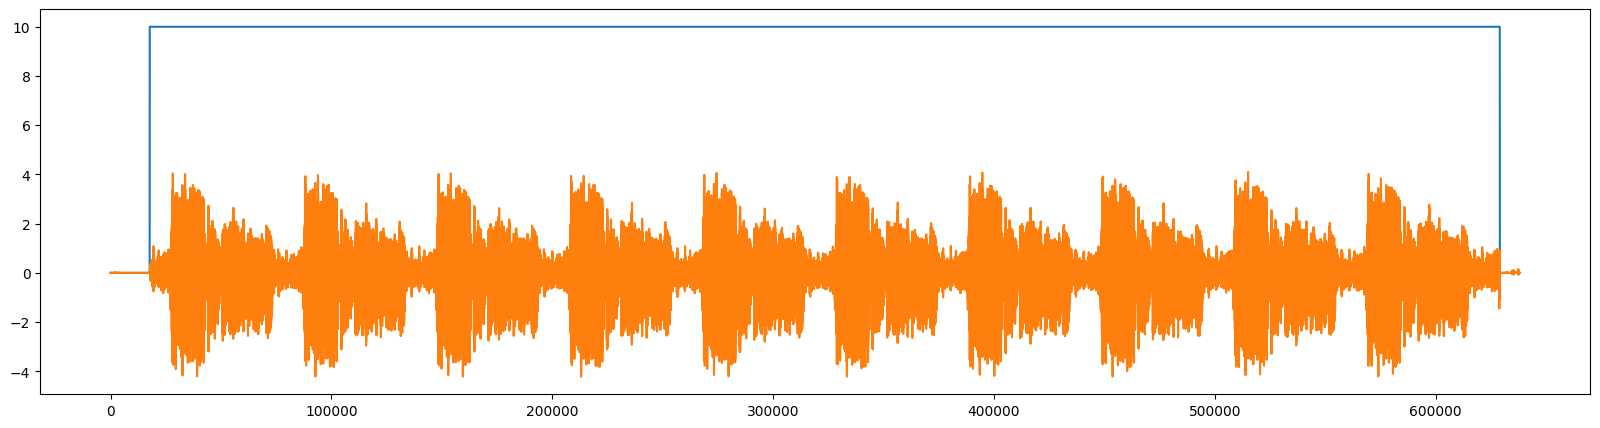

Computing initial lag for stimuli_auditory_localizer: 301 ms
Computing final story lag for stimuli_auditory_localizer: 590 ms
Rate for stimuli_auditory_localizer: 1.0004727529105384

Computing initial lag for stimuli_auditory_localizer: 0 ms
Computing final story lag for stimuli_auditory_localizer: 8 ms
Rate for stimuli_auditory_localizer: 1.000013073967606

Computing initial lag for stimuli_auditory_localizer: -1 ms
Computing final story lag for stimuli_auditory_localizer: 0 ms
Rate for stimuli_auditory_localizer: 1.0000016342219142

Computing initial lag for stimuli_auditory_localizer: 0 ms
Computing final story lag for stimuli_auditory_localizer: 0 ms
Rate for stimuli_auditory_localizer: 1.0

{'meg_sr': 1000, 'initial_lag': 300.0044271714767, 'initial_lag_time': 0.30000442717147674, 'rate': 1.000487468074774, 'meg_acoustic_diff': -611, 'meg_acoustic_diff_time': -0.611}
Saving corrected acoustic data (1k Hz) to /project_data/volume0/jerryjin/moth_meg/Moth1/delay_correction/corrected_

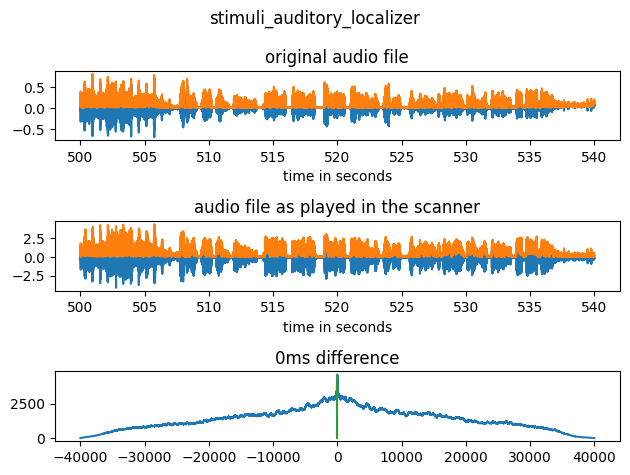

alternateithicatom1


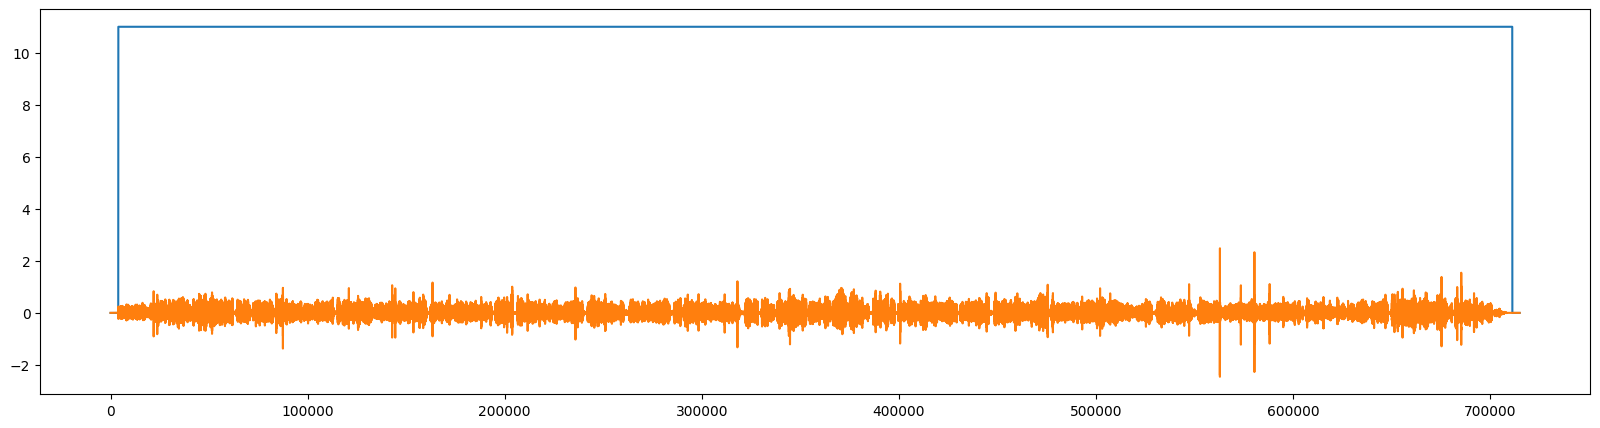

Computing initial lag for alternateithicatom1: 30 ms
Computing final story lag for alternateithicatom1: 368 ms
Rate for alternateithicatom1: 1.000478286094327

Computing initial lag for alternateithicatom1: -1 ms
Computing final story lag for alternateithicatom1: 6 ms
Rate for alternateithicatom1: 1.0000099001779204

Computing initial lag for alternateithicatom1: 0 ms
Computing final story lag for alternateithicatom1: 0 ms
Rate for alternateithicatom1: 1.0

{'meg_sr': 1000, 'initial_lag': 29.00029700533761, 'initial_lag_time': 0.02900029700533761, 'rate': 1.0004881910073649, 'meg_acoustic_diff': 285, 'meg_acoustic_diff_time': 0.285}
Saving corrected acoustic data (1k Hz) to /project_data/volume0/jerryjin/moth_meg/Moth1/delay_correction/corrected_acoustic_data/D/alternateithicatom1.pkl
Saving delay correction coefficients to /project_data/volume0/jerryjin/moth_meg/Moth1/delay_correction/coefficients/D/alternateithicatom1.pkl
Saving aligned audio files to /project_data/volume0/jerryjin/m

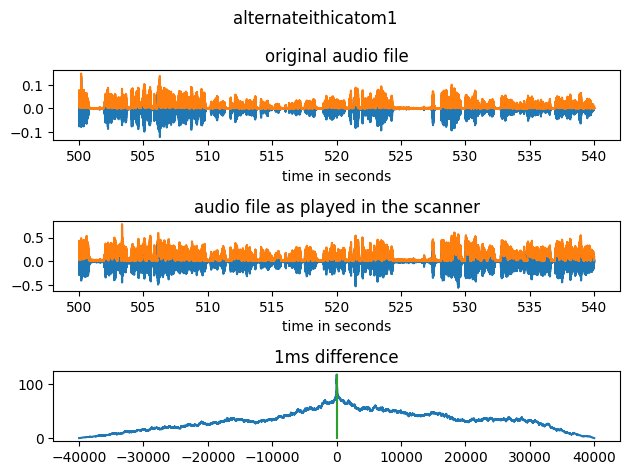

souls


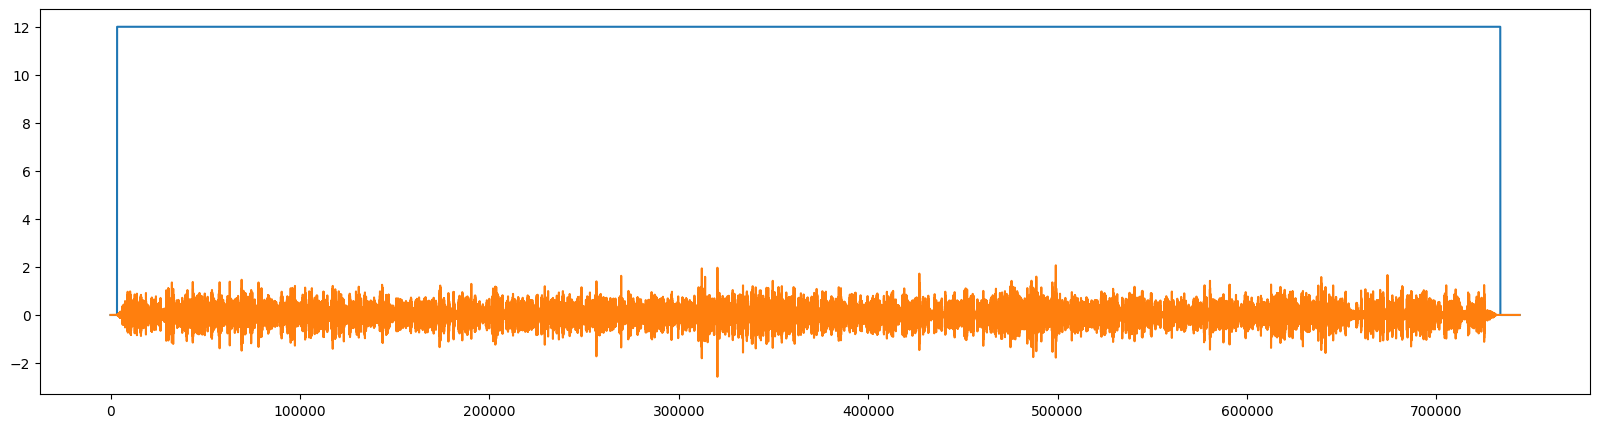

Computing initial lag for souls: 1 ms
Computing final story lag for souls: 381 ms
Rate for souls: 1.0005205479452055

Computing initial lag for souls: 28 ms
Computing final story lag for souls: 5 ms
Rate for souls: 0.9999685095860927

Computing initial lag for souls: 0 ms
Computing final story lag for souls: 0 ms
Rate for souls: 1.0

{'meg_sr': 1000, 'initial_lag': 28.999968509586093, 'initial_lag_time': 0.028999968509586093, 'rate': 1.000489041139028, 'meg_acoustic_diff': -26, 'meg_acoustic_diff_time': -0.026}
Saving corrected acoustic data (1k Hz) to /project_data/volume0/jerryjin/moth_meg/Moth1/delay_correction/corrected_acoustic_data/D/souls.pkl
Saving delay correction coefficients to /project_data/volume0/jerryjin/moth_meg/Moth1/delay_correction/coefficients/D/souls.pkl
Saving aligned audio files to /project_data/volume0/jerryjin/moth_meg/Moth1/delay_correction/wav_files_40k/D/souls.wav


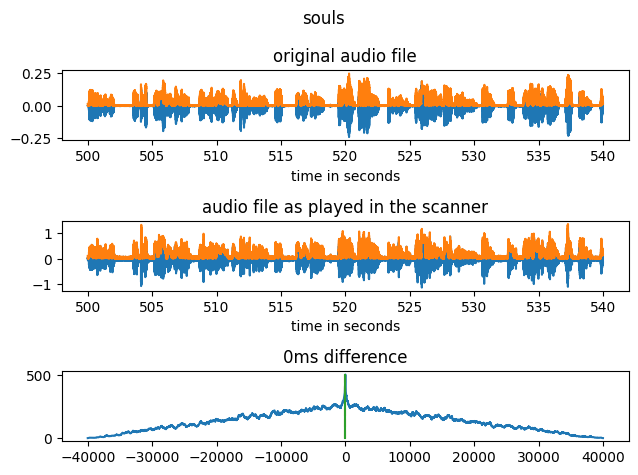

wheretheressmoke1


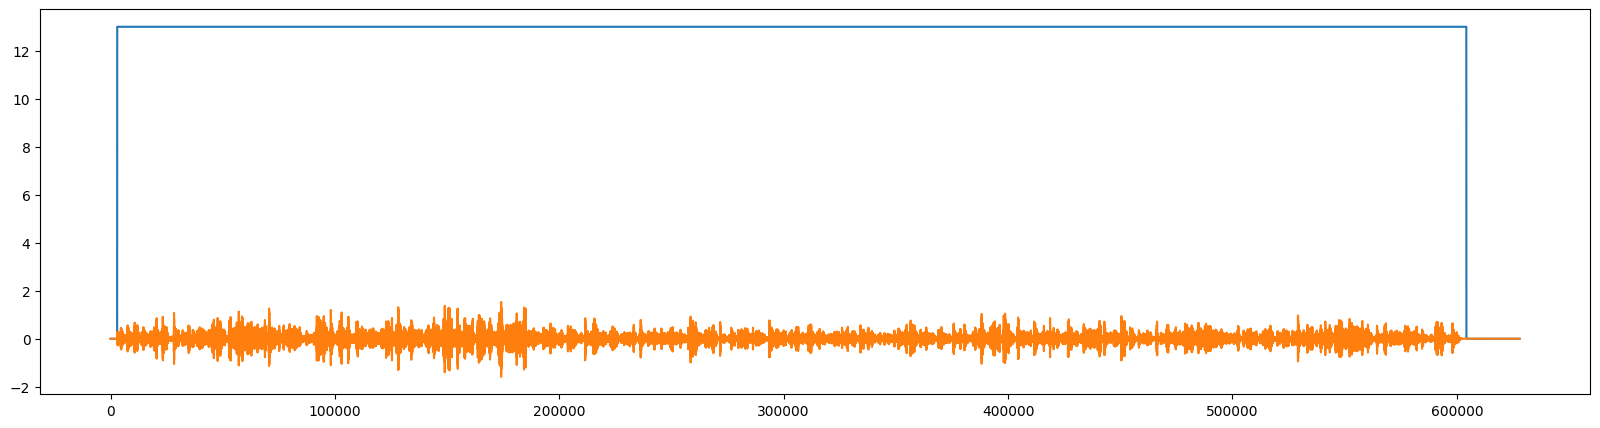

Computing initial lag for wheretheressmoke1: 30 ms
Computing final story lag for wheretheressmoke1: 317 ms
Rate for wheretheressmoke1: 1.0004767924989078

Computing initial lag for wheretheressmoke1: -1 ms
wheretheressmoke1 start_samp_meg + duration_samp is out of range of meg audio length, shortening to the end of the meg audio
Computing final story lag for wheretheressmoke1: 6 ms
Rate for wheretheressmoke1: 1.0000116229643208

Computing initial lag for wheretheressmoke1: 0 ms
wheretheressmoke1 start_samp_meg + duration_samp is out of range of meg audio length, shortening to the end of the meg audio
Computing final story lag for wheretheressmoke1: 0 ms
Rate for wheretheressmoke1: 1.0

{'meg_sr': 1000, 'initial_lag': 29.000348688929623, 'initial_lag_time': 0.029000348688929624, 'rate': 1.0004884210049707, 'meg_acoustic_diff': -966, 'meg_acoustic_diff_time': -0.966}
Saving corrected acoustic data (1k Hz) to /project_data/volume0/jerryjin/moth_meg/Moth1/delay_correction/corrected_acousti

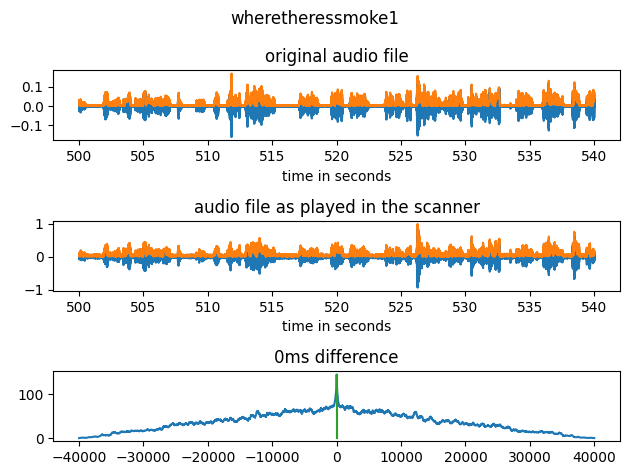

avatar


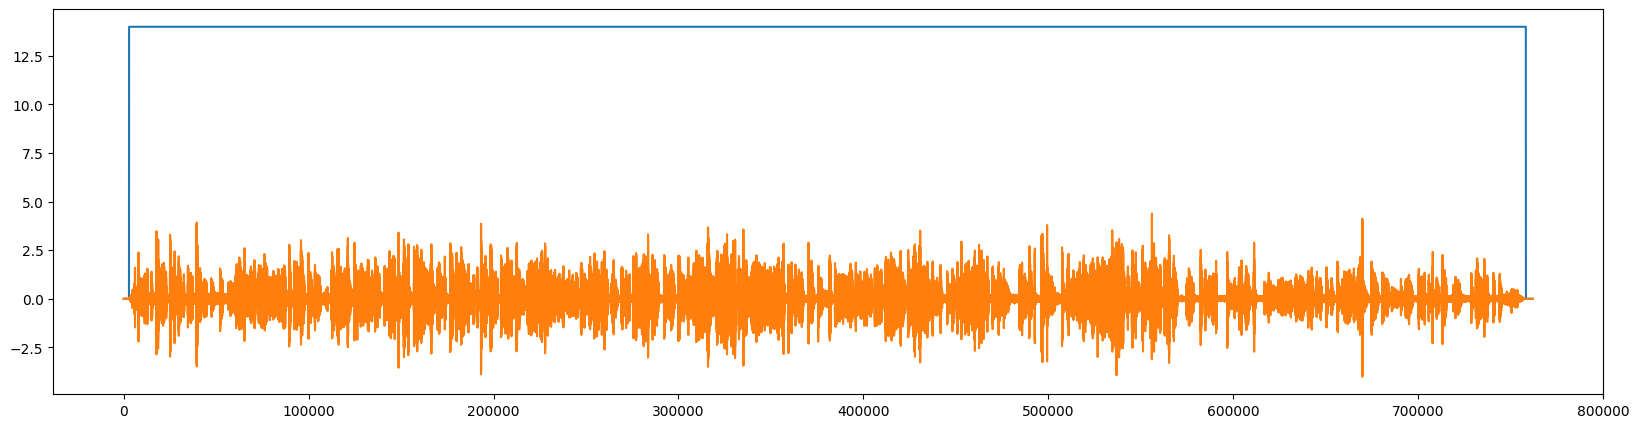

Computing initial lag for avatar: 40 ms
Computing final story lag for avatar: 392 ms
Rate for avatar: 1.0004666831950297

Computing initial lag for avatar: -10 ms
Computing final story lag for avatar: 6 ms
Rate for avatar: 1.0000212018535721

Computing initial lag for avatar: 0 ms
Computing final story lag for avatar: 0 ms
Rate for avatar: 1.0

{'meg_sr': 1000, 'initial_lag': 30.000848074142887, 'initial_lag_time': 0.030000848074142886, 'rate': 1.0004878949431506, 'meg_acoustic_diff': 715, 'meg_acoustic_diff_time': 0.715}
Saving corrected acoustic data (1k Hz) to /project_data/volume0/jerryjin/moth_meg/Moth1/delay_correction/corrected_acoustic_data/D/avatar.pkl
Saving delay correction coefficients to /project_data/volume0/jerryjin/moth_meg/Moth1/delay_correction/coefficients/D/avatar.pkl
Saving aligned audio files to /project_data/volume0/jerryjin/moth_meg/Moth1/delay_correction/wav_files_40k/D/avatar.wav


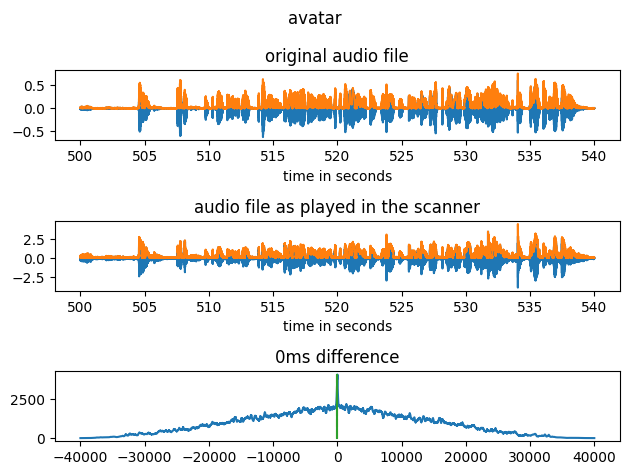

legacy


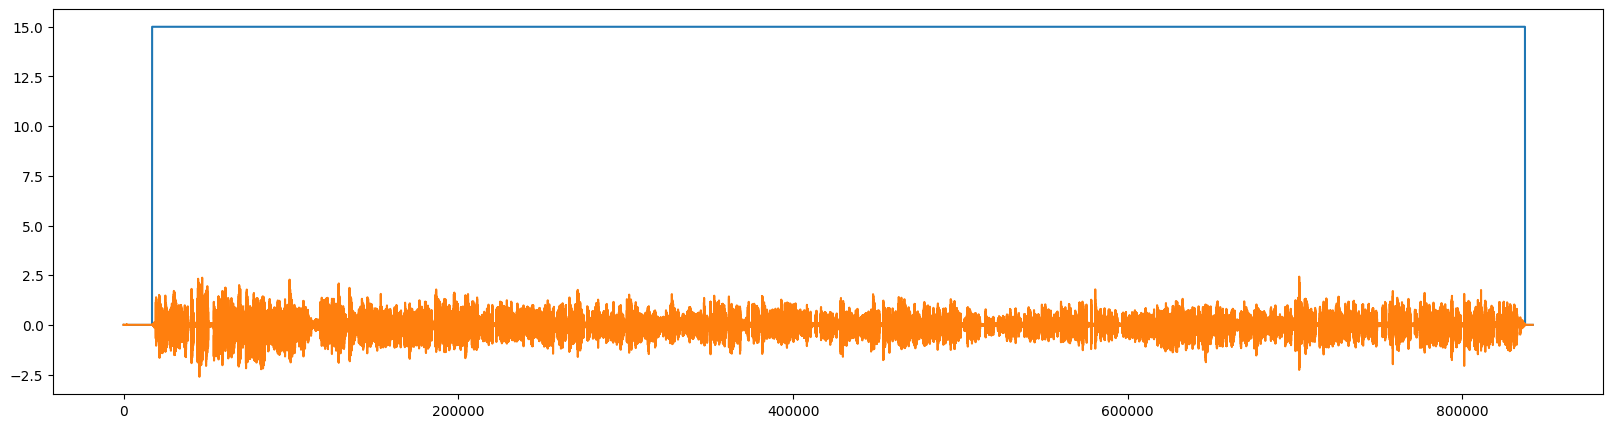

Computing initial lag for legacy: 759 ms
Computing final story lag for legacy: 1144 ms
Rate for legacy: 1.000469512195122

Computing initial lag for legacy: -1 ms
legacy start_samp_meg + duration_samp is out of range of meg audio length, shortening to the end of the meg audio
Computing final story lag for legacy: 15 ms
Rate for legacy: 1.0000194850111552

Computing initial lag for legacy: 0 ms
legacy start_samp_meg + duration_samp is out of range of meg audio length, shortening to the end of the meg audio
Computing final story lag for legacy: 0 ms
Rate for legacy: 1.0

{'meg_sr': 1000, 'initial_lag': 758.0147891234668, 'initial_lag_time': 0.7580147891234668, 'rate': 1.0004890063547276, 'meg_acoustic_diff': -756, 'meg_acoustic_diff_time': -0.756}
Saving corrected acoustic data (1k Hz) to /project_data/volume0/jerryjin/moth_meg/Moth1/delay_correction/corrected_acoustic_data/D/legacy.pkl
Saving delay correction coefficients to /project_data/volume0/jerryjin/moth_meg/Moth1/delay_correction

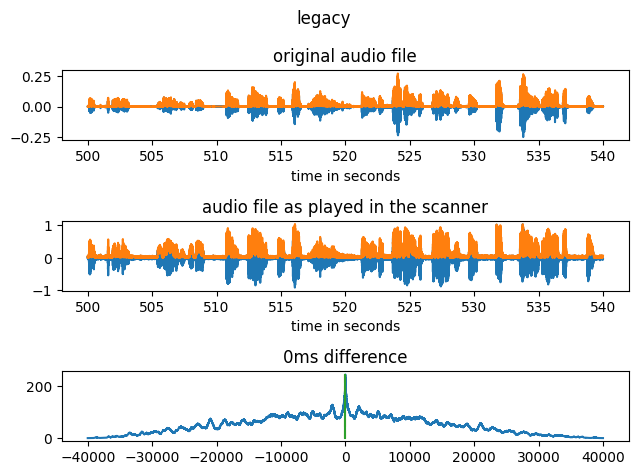

odetostepfather


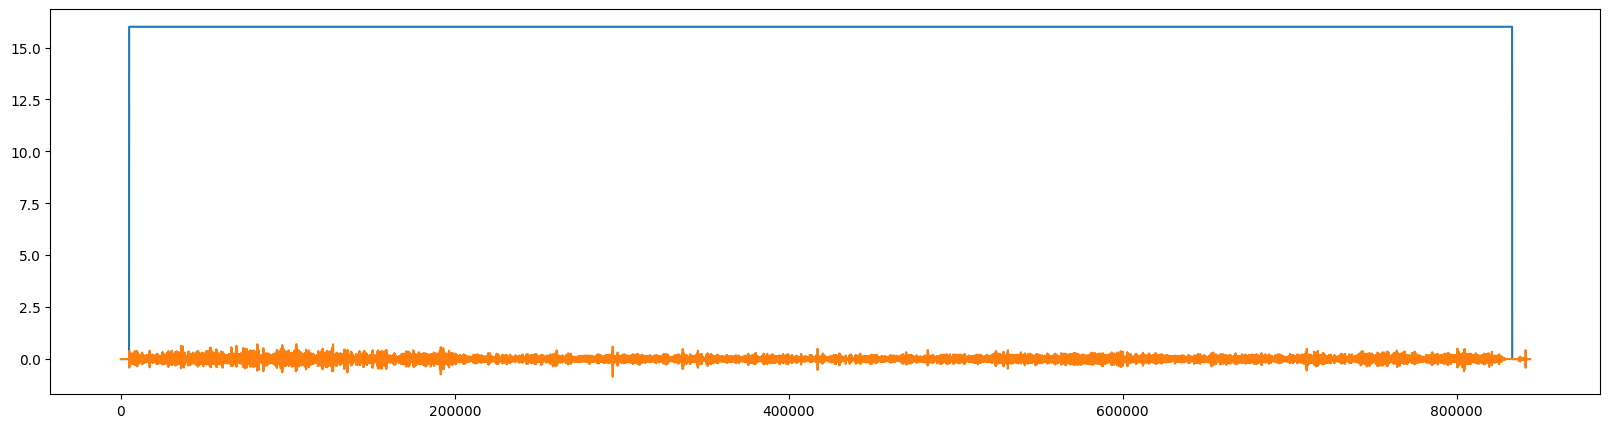

Computing initial lag for odetostepfather: 29 ms
Computing final story lag for odetostepfather: 418 ms
Rate for odetostepfather: 1.000469746059386

Computing initial lag for odetostepfather: 0 ms
Computing final story lag for odetostepfather: 15 ms
Rate for odetostepfather: 1.00001810446275

Computing initial lag for odetostepfather: 0 ms
Computing final story lag for odetostepfather: 0 ms
Rate for odetostepfather: 1.0

{'meg_sr': 1000, 'initial_lag': 29.00052502941975, 'initial_lag_time': 0.02900052502941975, 'rate': 1.0004878590266362, 'meg_acoustic_diff': -132, 'meg_acoustic_diff_time': -0.132}
Saving corrected acoustic data (1k Hz) to /project_data/volume0/jerryjin/moth_meg/Moth1/delay_correction/corrected_acoustic_data/D/odetostepfather.pkl
Saving delay correction coefficients to /project_data/volume0/jerryjin/moth_meg/Moth1/delay_correction/coefficients/D/odetostepfather.pkl
Saving aligned audio files to /project_data/volume0/jerryjin/moth_meg/Moth1/delay_correction/wav_files_40k

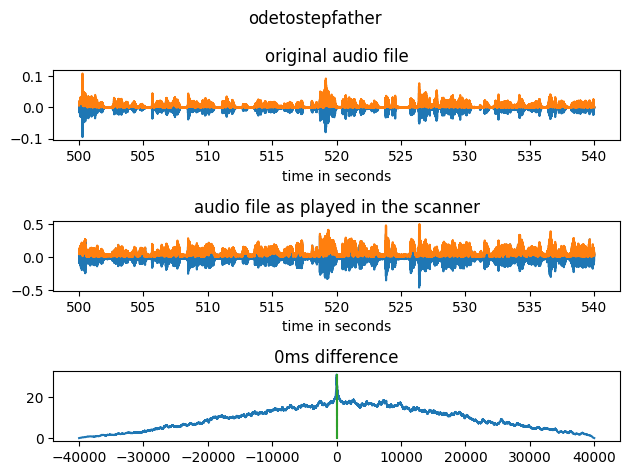

alternateithicatom2


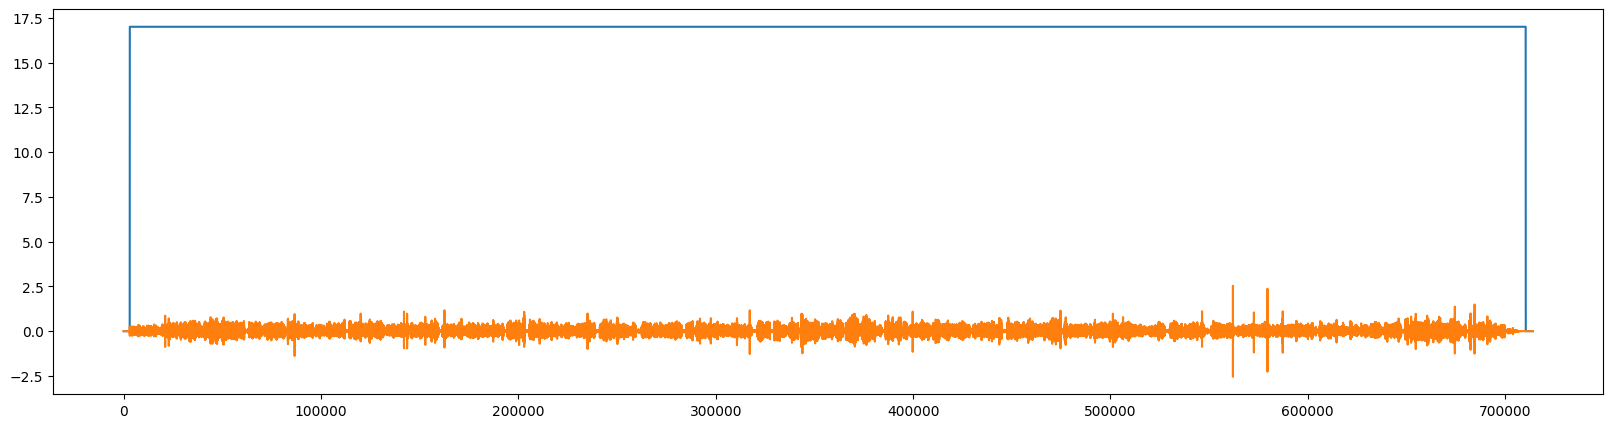

Computing initial lag for alternateithicatom2: 29 ms
Computing final story lag for alternateithicatom2: 367 ms
Rate for alternateithicatom2: 1.000478286094327

Computing initial lag for alternateithicatom2: -1 ms
Computing final story lag for alternateithicatom2: 6 ms
Rate for alternateithicatom2: 1.0000099001919223

Computing initial lag for alternateithicatom2: 0 ms
Computing final story lag for alternateithicatom2: 0 ms
Rate for alternateithicatom2: 1.0

{'meg_sr': 1000, 'initial_lag': 28.000287105565747, 'initial_lag_time': 0.028000287105565746, 'rate': 1.0004881910213734, 'meg_acoustic_diff': 286, 'meg_acoustic_diff_time': 0.286}
Saving corrected acoustic data (1k Hz) to /project_data/volume0/jerryjin/moth_meg/Moth1/delay_correction/corrected_acoustic_data/D/alternateithicatom2.pkl
Saving delay correction coefficients to /project_data/volume0/jerryjin/moth_meg/Moth1/delay_correction/coefficients/D/alternateithicatom2.pkl
Saving aligned audio files to /project_data/volume0/jerryjin

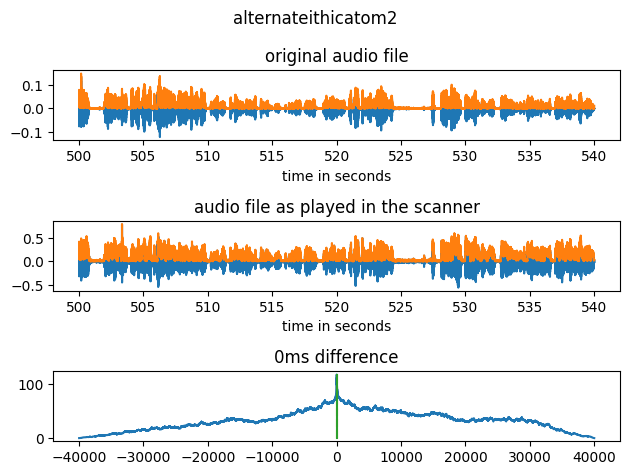

In [5]:
for BLOCK in BLOCKS:

    # get the story name
    record_id = int(BLOCK[-1])
    this_story = story_list[record_id - 1]
    this_story_unique = story_to_uniquestory[this_story]
    print(this_story)

    # load the raw file
    raw_file = glob.glob(LOC_RAW + f"*{SUBJECT}_{SESSION}_{BLOCK}*.fif")[0]
    raw = mne.io.read_raw_fif(raw_file, verbose=False)
    meg_sr = int(raw.info["sfreq"])

    # get stim channel data
    stim_ch_data = raw.copy().pick([STIM_CH]).get_data()[0]

    # fix discrepancies
    if SUBJECT == "C" and this_story == "undertheinfluence1":
        stim_ch_data[:16000] = 0
    if SUBJECT == "C" and this_story == "alternateithicatom1":  # my finding, how to save in the raw fif data?
        stim_ch_data[:4000] = 0
    if SUBJECT == "A" and SESSION == "Moth3":
        stim_ch_data[stim_ch_data > 0] += 10

    # get audio channel data
    audio_ch_data = raw.copy().pick([AUDIO_CH]).get_data()[0]

    # load the acoustic file (wav) of this story
    acoustic_file = LOC_AUDIO + f"{this_story_unique}.wav"
    acoustic_data = librosa.load(acoustic_file, sr=meg_sr)[0]

    # plot to check if the stim channel and audio channel are roughly aligned
    plt.subplots(figsize=(20, 5))
    plt.plot(stim_ch_data)
    plt.plot(audio_ch_data)
    plt.show()

    # compute initial lags and stretch rates
    initial_lag, rate = compute_meg_acoustic_diff(
        story=this_story,
        acoustic_data=acoustic_data,
        audio_ch_data=audio_ch_data,
        fs=meg_sr,
        stim_ch_data=stim_ch_data,
        STIM_ON_VAL=STIM_ON_VAL,
        initial_duration=3,  # be cautious with this
        final_duration=20,
    )

    # stretch the original audio to algin with MEG audio
    corrected_acoustic_data = stretch_shift_acoustic(
        acoustic_data=acoustic_data,
        fs=meg_sr,
        initial_lag=initial_lag,
        rate=rate,
    )

    # do this process iteratively so that it is more precise
    for _ in range(10):
        initial_lag_tmp, rate_tmp = compute_meg_acoustic_diff(
            story=this_story,
            acoustic_data=corrected_acoustic_data,
            audio_ch_data=audio_ch_data,
            fs=meg_sr,
            stim_ch_data=stim_ch_data,
            STIM_ON_VAL=STIM_ON_VAL,
            initial_duration=10,
            final_duration=20,
        )

        if rate_tmp == 1:
            break

        corrected_acoustic_data = stretch_shift_acoustic(
            acoustic_data=corrected_acoustic_data,
            fs=meg_sr,
            initial_lag=initial_lag_tmp,
            rate=rate_tmp,
        )

        rate *= rate_tmp
        initial_lag = initial_lag * rate_tmp + initial_lag_tmp

    # calculate meg_acoustic_diff and correct the final lags
    num_acoustic_samples = len(corrected_acoustic_data)
    num_meg_audio_samples = np.sum(stim_ch_data == STIM_ON_VAL[this_story])
    meg_acoustic_diff = num_meg_audio_samples - num_acoustic_samples
    corrected_acoustic_data = align_meg_acoustic_end(corrected_acoustic_data, meg_acoustic_diff)
    assert audio_ch_data[stim_ch_data == STIM_ON_VAL[this_story]].shape == corrected_acoustic_data.shape

    # The delay correlation coefficients (important for later analysis)
    delay_correction_coefs = {
        "meg_sr": meg_sr,
        "initial_lag": initial_lag,
        "initial_lag_time": initial_lag / meg_sr,
        "rate": rate,
        "meg_acoustic_diff": meg_acoustic_diff,
        "meg_acoustic_diff_time": meg_acoustic_diff / meg_sr,
    }
    print(delay_correction_coefs)

    # save the strethced acoustic data (1k Hz)
    corrected_acoustic_folder = LOC_SAVE + f"corrected_acoustic_data/{SUBJECT}"
    # if the directory does not exist, create it
    if not os.path.exists(corrected_acoustic_folder):
        os.makedirs(corrected_acoustic_folder)
    corrected_acoustic_path = f"{corrected_acoustic_folder}/{this_story}.pkl"
    print(f"Saving corrected acoustic data (1k Hz) to {corrected_acoustic_path}")
    with open(corrected_acoustic_path, "wb") as f:
        pickle.dump(corrected_acoustic_data, f)

    # save the coefficients of delay correction
    delay_correction_folder = LOC_SAVE + f"coefficients/{SUBJECT}"
    # if the directory does not exist, create it
    if not os.path.exists(delay_correction_folder):
        os.makedirs(delay_correction_folder)
    delay_correction_path = f"{delay_correction_folder}/{this_story}.pkl"
    print(f"Saving delay correction coefficients to {delay_correction_path}")
    with open(delay_correction_path, "wb") as f:
        pickle.dump(delay_correction_coefs, f)

    if SAVE_ACOUSTIC:
        # load the original acoustic data in 40k Hz
        highfs = 40000
        acoustic_data_highfs = librosa.load(acoustic_file, sr=highfs)[0]

        # correct the highfs acoustic data
        corrected_acoustic_data_highfs = stretch_shift_acoustic(
            acoustic_data=acoustic_data_highfs,
            fs=highfs,
            initial_lag=initial_lag,
            rate=rate,
        )
        scale_factor = highfs / meg_sr
        meg_acoustic_diff_highfs = int(num_meg_audio_samples * scale_factor - len(corrected_acoustic_data_highfs))
        corrected_acoustic_data_highfs = align_meg_acoustic_end(corrected_acoustic_data_highfs, meg_acoustic_diff_highfs)

        # folder to save the strethced acoustic data (40k Hz)
        wav_folder_40k = LOC_SAVE + f"wav_files_40k/{SUBJECT}"
        # if the directory does not exist, create it
        if not os.path.exists(wav_folder_40k):
            os.makedirs(wav_folder_40k)
        print(f"Saving aligned audio files to {wav_folder_40k}/{this_story}.wav")
        sf.write(f"{wav_folder_40k}/{this_story}.wav", corrected_acoustic_data_highfs, 40000)

        # verify the corrected 40k wav file
        test_corrected_acoustic_data = librosa.load(f"{wav_folder_40k}/{this_story}.wav", sr=meg_sr)[0]  # downsample to 1k Hz
        _ = determine_lag(
            story=this_story,
            acoustic_data=test_corrected_acoustic_data,
            fs=meg_sr,
            audio_ch_data=audio_ch_data[stim_ch_data == STIM_ON_VAL[this_story]],
            start=500,
            duration=40,
            plot=True,
        )